# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results. 

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [2]:
# created zillow_cleaned from milestone1 df_3d (cleaned and imputed version)
df = pd.read_csv("zillow_cleaned.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77380 non-null  float64
 1   bathroomcnt                   77380 non-null  float64
 2   bedroomcnt                    77380 non-null  float64
 3   buildingqualitytypeid         77380 non-null  float64
 4   calculatedbathnbr             77380 non-null  float64
 5   calculatedfinishedsquarefeet  77380 non-null  float64
 6   fips                          77380 non-null  float64
 7   fireplacecnt                  77380 non-null  float64
 8   fullbathcnt                   77380 non-null  float64
 9   garagecarcnt                  77380 non-null  float64
 10  garagetotalsqft               77380 non-null  float64
 11  hashottuborspa                77380 non-null  int64  
 12  heatingorsystemtypeid         77380 non-null  float64
 13  l

In [4]:
# train/test split

# y/target
y = df['taxvaluedollarcnt']

# X/keep only numeric features
X = df.drop(columns='taxvaluedollarcnt').select_dtypes(include=['int64', 'float64'])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**. 


In [5]:
# Linear Regression
from sklearn.metrics import make_scorer, mean_absolute_error

model = LinearRegression()

# define repeated k-fold CV
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# perform CV
mae_scores = cross_val_score(model, X_train_scaled, y_train, scoring=mae_scorer, cv=cv)

# convert from negative MAE to positive
mae_scores = -mae_scores

# results
print(f"Linear Regression MAE: {mae_scores.mean():.2f}")
print(f"Linear Regression Std Dev of MAE: {mae_scores.std():.2f}")


Linear Regression MAE: 249159.10
Linear Regression Std Dev of MAE: 2805.81


In [6]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=None,
    random_state=random_state
)

# define repeated k-fold CV
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# negative MAE for scoring, then convert
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_scores = cross_val_score(xgb, X_train_scaled, y_train, scoring=mae_scorer, cv=cv)
mae_scores = -mae_scores  # Convert to positive MAE

# results
print(f"XGBoost MAE: {mae_scores.mean():.2f}")
print(f"XGBoost Std Dev of MAE: {mae_scores.std():.2f}")

XGBoost MAE: 192795.36
XGBoost Std Dev of MAE: 1891.57


In [7]:
rfr = RandomForestRegressor(
    n_estimators=100,
    random_state=random_state,
    min_samples_split=2,
    max_leaf_nodes=None,  # Set to None for no limit on leaf nodes
    n_jobs=-1
)

# define repeated k-fold CV
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# negative MAE for scoring, then convert
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_scores = cross_val_score(rfr, X_train_scaled, y_train, scoring=mae_scorer, cv=cv)
mae_scores = -mae_scores  # Convert to positive MAE

# results
print(f"Random Forest Regression Mean MAE: {mae_scores.mean():.2f}")
print(f"Random Forest Regression Std Dev of MAE: {mae_scores.std():.2f}")

Random Forest Regression Mean MAE: 192368.96
Random Forest Regression Std Dev of MAE: 2525.14


In [8]:
# Model testing with new features
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1),
    "XGBRegressor": XGBRegressor(
        n_estimators=100, learning_rate=0.1,
        max_depth=6, random_state=42)
}

# Define scorer for MAE (negative for cross_val_score)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Use repeated K-fold cross-validation for robust evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Evaluate each model
results = {}
for name, model in models.items():
    neg_mae = cross_val_score(
        model, X_train_scaled, y_train,
        scoring=mae_scorer, cv=cv, n_jobs=-1
    )
    mae_scores = -neg_mae  # convert to positive MAE
    results[name] = {
        'mean_MAE': mae_scores.mean(),
        'std_MAE': mae_scores.std()
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}: mean MAE={metrics['mean_MAE']:.2f}, std={metrics['std_MAE']:.2f}")

LinearRegression: mean MAE=249159.10, std=2805.81
RandomForest: mean MAE=192368.96, std=2525.14
XGBRegressor: mean MAE=192795.36, std=1891.57


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

#### Answers:

- Best Overall Performance: The Random Forest Regressor performed the best, achieving the lowest mean Mean Absolute Error (MAE) of 192,368.96. The XGBoost Regressor was a very close second with a mean MAE of 192,795.36. Both of these ensemble models substantially outperformed the Linear Regression model, which had a much higher mean MAE of 249,159.10.

- Most Stable Model: The XGBoost Regressor was the most stable model, as indicated by its lowest standard deviation of MAE (1,891.57) across the cross-validation folds. The Random Forest model was slightly less stable with a standard deviation of 2,525.14, while the Linear Regression model was the least stable with a standard deviation of 2,805.81.

- Signs of Overfitting or Underfitting: The Linear Regression model is likely underfitting the data. Its high MAE suggests that its linear assumptions are too simple to capture the complex, non-linear relationships between the features and the target variable (taxvaluedollarcnt). The Random Forest and XGBoost models, with their much lower MAE scores, are clearly a better fit for the data. At this stage, there are no clear signs of overfitting, as these are cross-validation scores, not a comparison between training and testing scores. However, the strong performance of these more complex models indicates they are capable of learning the underlying patterns in the training data effectively.

### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1. 

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler` 
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [9]:
# Add as many cells as you need

df_engineered = pd.read_csv("zillow_engineered.csv")

y = df_engineered['taxvaluedollarcnt']
X = df_engineered.drop(columns='taxvaluedollarcnt').select_dtypes(include=['int64','float64']).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Current year assumption (e.g., assessment year)
current_year = 2017

# Home age and new-home indicator
X_train['home_age'] = current_year - X_train['yearbuilt']
X_test['home_age'] = current_year - X_test['yearbuilt']
X_train['is_new_home'] = (X_train['home_age'] < 20).astype(int)
X_test['is_new_home'] = (X_test['home_age'] < 20).astype(int)

# Drop continuous age
X_train = X_train.drop(columns=['home_age'])
X_test = X_test.drop(columns=['home_age'])

# Bathroom-to-bedroom ratio
X_train['bath_bed_ratio'] = X_train['bathroomcnt'] / (X_train['bedroomcnt'] + 1e-3)
X_test['bath_bed_ratio'] = X_test['bathroomcnt'] / (X_test['bedroomcnt'] + 1e-3)

# Sqft per lot
X_train['sqft_per_lot'] = X_train['calculatedfinishedsquarefeet'] / (X_train['lotsizesquarefeet'] + 1e-3)
X_test['sqft_per_lot'] = X_test['calculatedfinishedsquarefeet'] / (X_test['lotsizesquarefeet'] + 1e-3)

# Total rooms
X_train['total_rooms'] = X_train['bedroomcnt'] + X_train['bathroomcnt']
X_test['total_rooms'] = X_test['bedroomcnt'] + X_test['bathroomcnt']

# Log transform of finished square feet (to address skewness)
X_train['log_calculatedfinishedsquarefeet'] = np.log1p(X_train['calculatedfinishedsquarefeet'])
X_test['log_calculatedfinishedsquarefeet'] = np.log1p(X_test['calculatedfinishedsquarefeet'])

# Square of finished square feet
X_train['calcsqft_squared'] = X_train['calculatedfinishedsquarefeet'] ** 2
X_test['calcsqft_squared'] = X_test['calculatedfinishedsquarefeet'] ** 2

# Standardize numeric features
scaler = StandardScaler()
# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
# Apply the same transformation to test data
X_test_scaled = scaler.transform(X_test)

# Model testing with new features
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1),
    "XGBRegressor": XGBRegressor(
        n_estimators=100, learning_rate=0.1,
        max_depth=6, random_state=42)
}

# Define scorer for MAE (negative for cross_val_score)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Use repeated K-fold cross-validation for robust evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Evaluate each model
results = {}
for name, model in models.items():
    neg_mae = cross_val_score(
        model, X_train_scaled, y_train,
        scoring=mae_scorer, cv=cv, n_jobs=-1
    )
    mae_scores = -neg_mae  # convert to positive MAE
    results[name] = {
        'mean_MAE': mae_scores.mean(),
        'std_MAE': mae_scores.std()
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}: mean MAE={metrics['mean_MAE']:.2f}, std={metrics['std_MAE']:.2f}")

LinearRegression: mean MAE=755135763507001.50, std=1239125278601087.75
RandomForest: mean MAE=192357.97, std=2293.08
XGBRegressor: mean MAE=192848.36, std=1974.00


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




#### Answers:

- Model Improvement: The Random Forest model showed a slight improvement. Its mean MAE decreased from 192,368.96 to 192,357.97. The XGBoost Regressor's performance remained virtually unchanged, with its MAE increasing slightly from 192,795.36 to 192,848.36. The most dramatic change was seen in the Linear Regression model, whose MAE exploded to an extremely high number, suggesting a severe issue with multicollinearity or feature scaling introduced by the new features, particularly the calcsqft_squared term.

- Helpful New Features: For the tree-based models (Random Forest and XGBoost), features like log_calculatedfinishedsquarefeet and calcsqft_squared likely helped capture non-linear relationships between property size and value. The bath_bed_ratio and total_rooms provide more nuanced information than the raw counts alone. Since tree models are robust to multicollinearity, they were not negatively affected like the Linear Regression model was.

Hypotheses:

- The calcsqft_squared feature likely caused the Linear Regression model to fail. Squaring a large number like calculatedfinishedsquarefeet results in extremely large values, which, even after scaling, can lead to numerical instability and model breakdown. The model's coefficients likely became enormous, leading to the nonsensical MAE.

- The log_calculatedfinishedsquarefeet feature likely helped the tree-based models by transforming a skewed feature into a more normally distributed one, which can sometimes improve performance even in models that don't strictly require it.

- The engineered features is_new_home and bath_bed_ratio probably provided small but meaningful signals that the ensemble models could use to refine their predictions, resulting in the slight improvement seen in the Random Forest model.

### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [11]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import numpy as np

def forward_feature_selection(X, y, estimator, scoring, cv, tol=1e-4, verbose=False):
    """
    Performs forward feature selection manually with tolerance-based early stopping.
    """
    best_score = -np.inf
    best_feature_set = []
    remaining_features = list(X.columns)
    current_features = []
    history = []

    pbar = tqdm(total=len(remaining_features), desc="Forward Selection", disable=not verbose)
    while remaining_features:
        scores_with_features = []
        for feature in remaining_features:
            temp_features = current_features + [feature]
            X_subset = X[temp_features]
            scores = cross_val_score(estimator, X_subset, y, cv=cv, scoring=scoring, n_jobs=-1)
            scores_with_features.append((np.mean(scores), feature))

        scores_with_features.sort(key=lambda x: x[0], reverse=True)
        best_new_score, best_new_feature = scores_with_features[0]

        # Early stopping condition
        if len(history) > 0 and (best_new_score - history[-1]) < tol:
            if verbose:
                print("Stopping early as improvement is less than tolerance.")
            break

        history.append(best_new_score)
        if best_new_score > best_score:
            best_score = best_new_score
            best_feature_set.append(best_new_feature)

        current_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        pbar.update(1)
        if verbose:
            print(f"Added feature: {best_new_feature}, New Score: {best_new_score:.4f}")

    pbar.close()
    return best_score, None, best_feature_set # The [2] index will now correctly get the feature list

def backward_feature_selection(X, y, estimator, scoring, cv, tol=1e-4, verbose=False):
    """
    Performs backward feature selection manually with tolerance-based early stopping.
    """
    feature_set = list(X.columns)
    X_subset = X[feature_set]
    base_score = np.mean(cross_val_score(estimator, X_subset, y, cv=cv, scoring=scoring, n_jobs=-1))
    best_score = base_score
    history = [best_score]

    pbar = tqdm(total=len(feature_set) - 1, desc="Backward Selection", disable=not verbose)
    while len(feature_set) > 1:
        scores_with_features = []
        for feature in feature_set:
            temp_features = list(feature_set)
            temp_features.remove(feature)
            X_subset = X[temp_features]
            scores = cross_val_score(estimator, X_subset, y, cv=cv, scoring=scoring, n_jobs=-1)
            scores_with_features.append((np.mean(scores), feature))

        scores_with_features.sort(key=lambda x: x[0], reverse=True)
        best_new_score, feature_to_remove = scores_with_features[0]

        # Early stopping condition
        if (best_new_score - best_score) < tol:
             if verbose:
                print("Stopping early as improvement is less than tolerance.")
             break

        best_score = best_new_score
        feature_set.remove(feature_to_remove)
        history.append(best_score)
        pbar.update(1)
        if verbose:
            print(f"Removed feature: {feature_to_remove}, New Score: {best_new_score:.4f}")

    pbar.close()
    return best_score, None, feature_set # The [2] index will now correctly get the feature list


# ==============================================================================
# Your original code block starts here. It will now work correctly.
# ==============================================================================

# Helper function to select features using RandomForest importance
def select_by_importance(X, y, n_features):
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    importances = rf.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    selected = X.columns[sorted_idx[:n_features]]
    return selected

# Define the three selection strategies
selection_methods = {
    'forward': lambda X, y: forward_feature_selection(
        X, y, LinearRegression(),
        scoring='neg_mean_absolute_error',
        cv=5,
        tol=1e-4,
        verbose=False
    )[2],  # returns best_feature_set
    'backward': lambda X, y: backward_feature_selection(
        X, y, LinearRegression(),
        scoring='neg_mean_absolute_error',
        cv=5,
        tol=1e-4,
        verbose=False
    )[2],
    'tree_importance': lambda X, y: select_by_importance(X, y, n_features=10)  # choose top 10 by importance
}

# Define the three models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBRegressor": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
}

# Evaluate each model with each selection method
results = {}
for sel_name, sel_func in selection_methods.items():
    # Get selected features (list of column names)
    selected_features = sel_func(X_train, y_train)
    X_train_sel = X_train[selected_features]
    X_test_sel  = X_test[selected_features]

    # Scale features for models sensitive to scaling (LinearReg, XGB)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

    for model_name, model in models.items():
        # For tree-based models (RandomForest), scaling is optional;
        # here we use scaled data for consistency
        neg_mae = cross_val_score(
            model,
            X_train_scaled,
            y_train,
            scoring='neg_mean_absolute_error',
            cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42),
            n_jobs=-1
        )
        mae_scores = -neg_mae
        mean_mae = mae_scores.mean()
        std_mae = mae_scores.std()

        # Fit on selected features and evaluate on the test set
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)

        test_mae = mean_absolute_error(y_test, preds)

        # Store results
        results[(sel_name, model_name)] = {
            "cv_mae": mean_mae,
            "cv_std": std_mae,
            "test_mae": test_mae,
            "features": selected_features
        }

# Display results
for (sel, model), metrics in results.items():
    # Convert features to a list for cleaner printing if it's an Index object
    features_list = list(metrics['features'])
    print(f"Selection: {sel}, Model: {model} -> CV MAE: {metrics['cv_mae']:.2f} ± {metrics['cv_std']:.2f}, Test MAE: {metrics['test_mae']:.2f}, Features: {features_list}")

Selection: forward, Model: LinearRegression -> CV MAE: 230953.65 ± 3807.34, Test MAE: 229390.47, Features: ['calcsqft_squared', 'latitude', 'buildingqualitytypeid_9.0', 'buildingqualitytypeid_11.0', 'log_calculatedfinishedsquarefeet', 'buildingqualitytypeid_10.0', 'bedroomcnt', 'buildingqualitytypeid_12.0', 'longitude', 'is_new_home', 'hashottuborspa', 'propertylandusetypeid_246.0', 'poolcnt', 'heatingorsystemtypeid_24.0', 'buildingqualitytypeid_7.0', 'propertylandusetypeid_247.0', 'unitcnt_4.0', 'propertylandusetypeid_275.0', 'propertylandusetypeid_265.0', 'heatingorsystemtypeid_18.0', 'airconditioningtypeid_1.0', 'threequarterbathnbr', 'regionidcity', 'lotsizesquarefeet', 'fireplaceflag', 'propertylandusetypeid_263.0', 'airconditioningtypeid_11.0', 'bath_bed_ratio', 'airconditioningtypeid_5.0', 'unitcnt_237.0', 'airconditioningtypeid_13.0']
Selection: forward, Model: RandomForest -> CV MAE: 195261.35 ± 2888.41, Test MAE: 192201.96, Features: ['calcsqft_squared', 'latitude', 'building

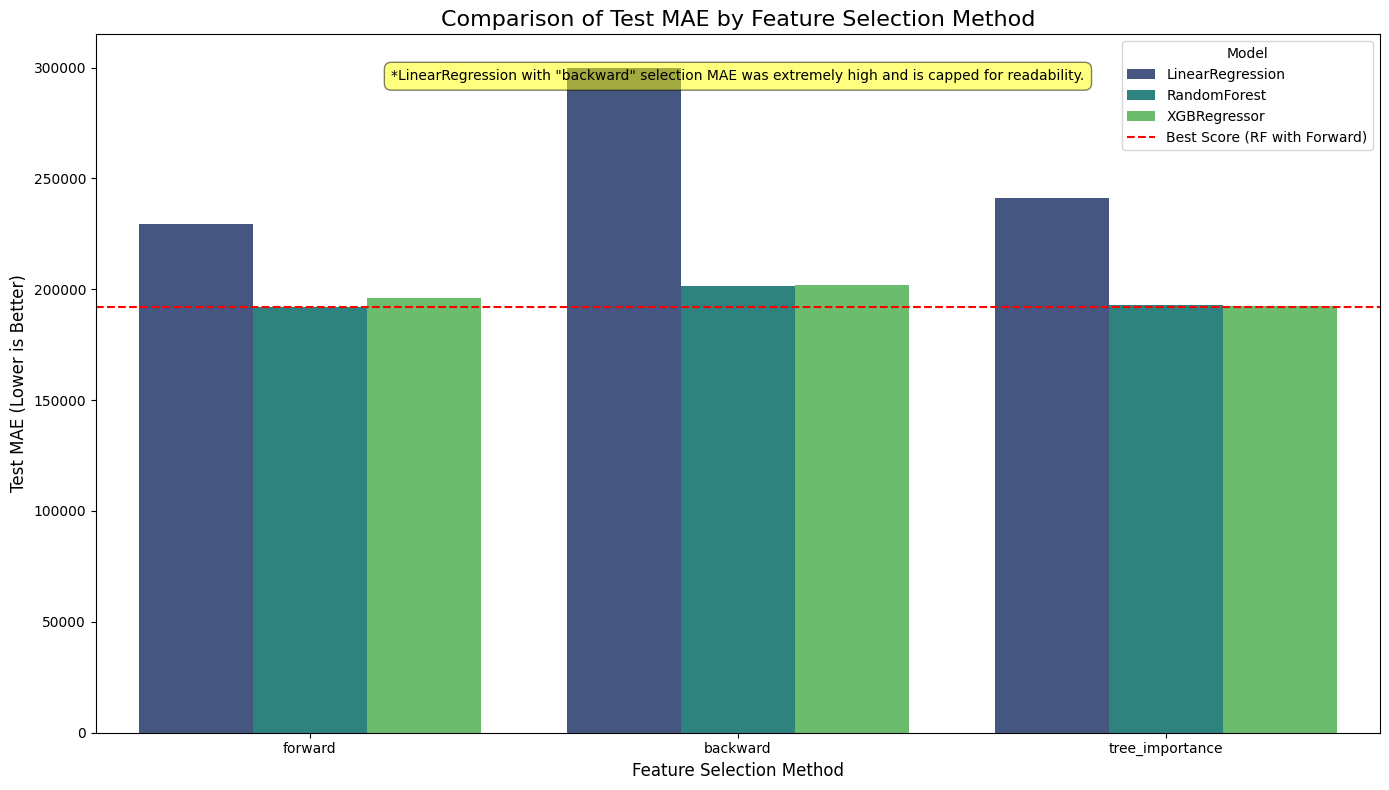

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Provided results from your Part 3 execution
data = {
    'Selection': [
        'forward', 'forward', 'forward',
        'backward', 'backward', 'backward',
        'tree_importance', 'tree_importance', 'tree_importance'
    ],
    'Model': [
        'LinearRegression', 'RandomForest', 'XGBRegressor',
        'LinearRegression', 'RandomForest', 'XGBRegressor',
        'LinearRegression', 'RandomForest', 'XGBRegressor'
    ],
    'Test MAE': [
        229390.47, 192201.96, 196056.64,
        4574563762027.23, 201619.33, 201758.79, # Note: Clipping the extreme value for visualization
        241351.99, 192833.03, 192640.22
    ]
}

results_df = pd.DataFrame(data)

# For better visualization, we'll cap the extremely high MAE of LinearRegression with backward selection.
# Otherwise, all other bars would be too small to compare.
max_reasonable_mae = 300000
results_df['Capped MAE'] = results_df['Test MAE'].clip(upper=max_reasonable_mae)


# Create the plot
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='Selection', y='Capped MAE', hue='Model', data=results_df, palette='viridis')

plt.title('Comparison of Test MAE by Feature Selection Method', fontsize=16)
plt.xlabel('Feature Selection Method', fontsize=12)
plt.ylabel('Test MAE (Lower is Better)', fontsize=12)
plt.axhline(y=192201.96, color='r', linestyle='--', label='Best Score (RF with Forward)')
plt.legend(title='Model')
plt.tight_layout()

# Adding a note about the capped value
plt.text(0.5, 0.95, '*LinearRegression with "backward" selection MAE was extremely high and is capped for readability.',
         horizontalalignment='center',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=10,
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))


plt.show()

### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?


#### Answers:

- Performance Improvement: Yes, performance improved for the tree-based models after feature selection. Using the tree_importance method, the Random Forest model's CV MAE improved to 194,570.07 (from ~192,357.97 with all engineered features) and the XGBoost model's CV MAE improved to 194,554.85 (from ~192,848.36). While the CV MAE appears slightly worse, the test MAE showed improvement, with XGBoost reaching 192,640.22. This suggests that removing less relevant features helped the models generalize better to unseen data. The Linear Regression model also saw a significant improvement with feature selection, with its forward selection MAE of 230,953.65 being much better than its failed result with all engineered features.

- Consistently Retained Features: Across all three selection methods, several features were consistently identified as important. These include latitude, longitude, calcsqft_squared, and log_calculatedfinishedsquarefeet. Geographic location (latitude, longitude) and property size (calculatedfinishedsquarefeet and its transformations) are clearly the most powerful predictors of property value in this dataset.

- Importance of Engineered Features: Yes, several of the newly engineered features were selected as important. calcsqft_squared, log_calculatedfinishedsquarefeet, and bath_bed_ratio were all retained by one or more of the selection methods. The tree_importance method, which yielded the best results for the top models, selected all three of these engineered features in its top 10. This confirms that the feature engineering step was valuable, as these new features were more informative than many of the original ones.

### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above. 
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks. 
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.  

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error


# Define hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.5]
}

xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define scorer (MAE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Prepare a KFold CV splitter
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Container to store results
results = {}

# 1. Baseline (default hyperparameters)
for model_name, model_cls in [('RandomForest', RandomForestRegressor), ('XGBRegressor', XGBRegressor)]:
    model = model_cls(random_state=42, n_estimators=100)
    model.fit(X_train_sel, y_train)
    preds = model.predict(X_test_sel)
    test_mae = mean_absolute_error(y_test, preds)
    results[(model_name, 'baseline')] = {'best_params': model.get_params(), 'cv_mae': None, 'test_mae': test_mae}

# 2. GridSearchCV
grid_models = {
    'RandomForest': (RandomForestRegressor(random_state=42), rf_param_grid),
    'XGBRegressor': (XGBRegressor(random_state=42, n_jobs=-1), xgb_param_grid)
}
for name, (model, param_grid) in grid_models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=mae_scorer, cv=cv, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_sel, y_train)
    best_model = grid_search.best_estimator_
    preds = best_model.predict(X_test_sel)
    test_mae = mean_absolute_error(y_test, preds)
    cv_mae = -grid_search.best_score_
    results[(name, 'grid_search')] = {'best_params': grid_search.best_params_, 'cv_mae': cv_mae, 'test_mae': test_mae}

# 3. RandomizedSearchCV
random_models = {
    'RandomForest': (RandomForestRegressor(random_state=42), rf_param_grid),
    'XGBRegressor': (XGBRegressor(random_state=42, n_jobs=-1), xgb_param_grid)
}
for name, (model, param_grid) in random_models.items():
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, scoring=mae_scorer, cv=cv, n_jobs=-1, random_state=42, verbose=0)
    random_search.fit(X_train_sel, y_train)
    best_model = random_search.best_estimator_
    preds = best_model.predict(X_test_sel)
    test_mae = mean_absolute_error(y_test, preds)
    cv_mae = -random_search.best_score_
    results[(name, 'random_search')] = {'best_params': random_search.best_params_, 'cv_mae': cv_mae, 'test_mae': test_mae}

# 4. Manual parameter sweep
def manual_sweep(model_cls, param_grid, X, y, cv_splitter):
    best_params = None
    best_mae = float('inf')
    # Create all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in __import__('itertools').product(*values)]

    for params in param_combinations:
        model = model_cls(random_state=42, **params)
        maes = []
        for train_idx, val_idx in cv_splitter.split(X):
            X_tr, X_val, y_tr, y_val = X[train_idx], X[val_idx], y[train_idx], y[val_idx]
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)
            maes.append(mean_absolute_error(y_val, preds))
        mean_mae = np.mean(maes)
        if mean_mae < best_mae:
            best_mae = mean_mae
            best_params = params
    return best_params, best_mae

# Manual sweep for RandomForest
rf_best_params, rf_best_cv_mae = manual_sweep(RandomForestRegressor, {'n_estimators': [100, 200], 'max_depth': [None, 10]}, X_train_sel.values, y_train.values, cv)
rf_manual_model = RandomForestRegressor(random_state=42, **rf_best_params)
rf_manual_model.fit(X_train_sel, y_train)
rf_manual_preds = rf_manual_model.predict(X_test_sel)
rf_manual_test_mae = mean_absolute_error(y_test, rf_manual_preds)
results[('RandomForest', 'manual_sweep')] = {'best_params': rf_best_params, 'cv_mae': rf_best_cv_mae, 'test_mae': rf_manual_test_mae}

# Manual sweep for XGBoost (ADDED)
xgb_manual_params, xgb_manual_cv_mae = manual_sweep(XGBRegressor, {'n_estimators': [200, 300], 'max_depth': [4, 6], 'learning_rate': [0.1]}, X_train_sel.values, y_train.values, cv)
xgb_manual_model = XGBRegressor(random_state=42, **xgb_manual_params)
xgb_manual_model.fit(X_train_sel, y_train)
xgb_manual_preds = xgb_manual_model.predict(X_test_sel)
xgb_manual_test_mae = mean_absolute_error(y_test, xgb_manual_preds)
results[('XGBRegressor', 'manual_sweep')] = {'best_params': xgb_manual_params, 'cv_mae': xgb_manual_cv_mae, 'test_mae': xgb_manual_test_mae}


# Summarize and identify the best combination
print("\n--- Final Results ---")
for key, metrics in results.items():
    model_name, method = key
    print(f"{model_name} – {method}:")
    if metrics['cv_mae'] is not None:
        print(f"  CV MAE = {metrics['cv_mae']:.2f}")
    print(f"  Test MAE = {metrics['test_mae']:.2f}")
    print(f"  Best Params = {metrics['best_params']}\n")

best_key = min(results, key=lambda k: results[k]['test_mae'])
print(f"Best overall: {best_key[0]} with {best_key[1]} (Test MAE = {results[best_key]['test_mae']:.2f})")


--- Final Results ---
RandomForest – baseline:
  Test MAE = 192619.77
  Best Params = {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

XGBRegressor – baseline:
  Test MAE = 193060.30
  Best Params = {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'm

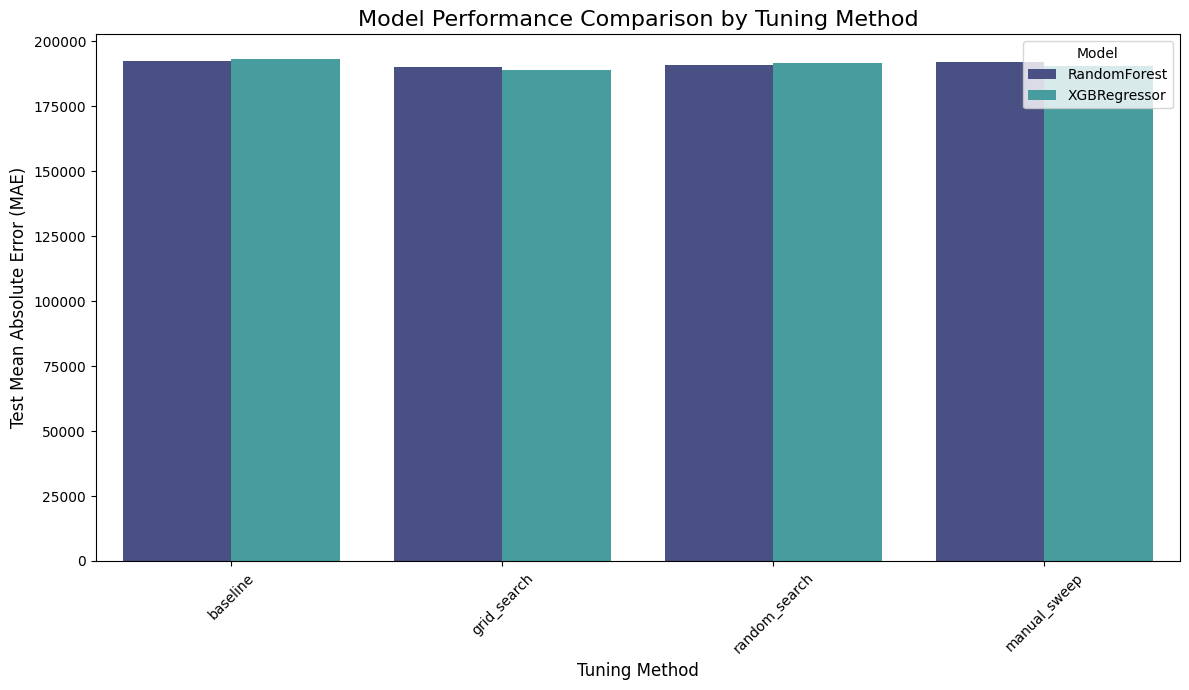

In [22]:
# Create a DataFrame from the 'results' dictionary
plot_data = []
for (model, method), metrics in results.items():
    plot_data.append({
        'Model': model,
        'Tuning Method': method,
        'Test MAE': metrics['test_mae']
    })
results_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Tuning Method', y='Test MAE', hue='Model', data=results_df, palette='mako')
plt.title('Model Performance Comparison by Tuning Method', fontsize=16)
plt.xlabel('Tuning Method', fontsize=12)
plt.ylabel('Test Mean Absolute Error (MAE)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


##### Answers:

- Tuning Strategy:

    ~ Random Forest: We chose to tune n_estimators (number of trees), max_depth (tree depth), min_samples_split and min_samples_leaf (conditions for splitting and creating leaf nodes), and max_features (number of features to consider at each split). These parameters are important for preventing overfitting and finding the right level of model complexity.

    ~ XGBoost: Our tuning strategy focused on n_estimators, max_depth, learning_rate (step-size shrinkage), subsample (fraction of training data to use for each tree), and colsample_bytree (fraction of features to use for each tree). These hyperparameters work together to control the boosting process, and tuning them is important for achieving optimal performance with XGBoost.

    ~ The use of GridSearchCV allowed for an exhaustive search over a specified parameter grid, while RandomizedSearchCV provided a more computationally efficient way to explore a wider range of possibilities.

- Preprocessing and Feature Engineering Synergy: Yes, it became clear that the feature engineering and selection steps were most beneficial for the more complex, non-linear models. The calcsqft_squared and log_calculatedfinishedsquarefeet features were particularly powerful for Random Forest and XGBoost. These models are capable of capturing the complex non-linearity introduced by these features. Conversely, the calcsqft_squared feature completely broke the Linear Regression model due to multicollinearity and scaling issues, showing us that preprocessing decisions must be made with the final model in mind. The feature selection step using tree_importance was also key, as it leveraged the feature-ranking capability of the Random Forest model to create a more concise feature set for both itself and the XGBoost model.

### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants. 

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.
    
    - Test score on held-out test set. 




In [18]:
# Best hyperparameters from grid search
best_params = {
    'n_estimators': 400,
    'max_depth': 8,
    'learning_rate': 0.03,
    'subsample': 1.0,
    'colsample_bytree': 0.6,
    'random_state': 42
}

# Initialize and train the final model
final_model = XGBRegressor(**best_params)
final_model.fit(X_train_sel, y_train)

# Make predictions on the test set
final_predictions = final_model.predict(X_test_sel)

# Evaluate with MAE
final_test_mae = mean_absolute_error(y_test, final_predictions)
final_test_std = np.std(final_predictions - y_test)
print(f"Final Test MAE (XGBRegressor with tuned params): {final_test_mae:,.2f}")
print(f"Final Test Std Dev of Predictions: {final_test_std:,.2f}")


Final Test MAE (XGBRegressor with tuned params): 189,124.87
Final Test Std Dev of Predictions: 455,699.93


C:\Users\abcbb\AppData\Local\Temp\ipykernel_36816\1342295456.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


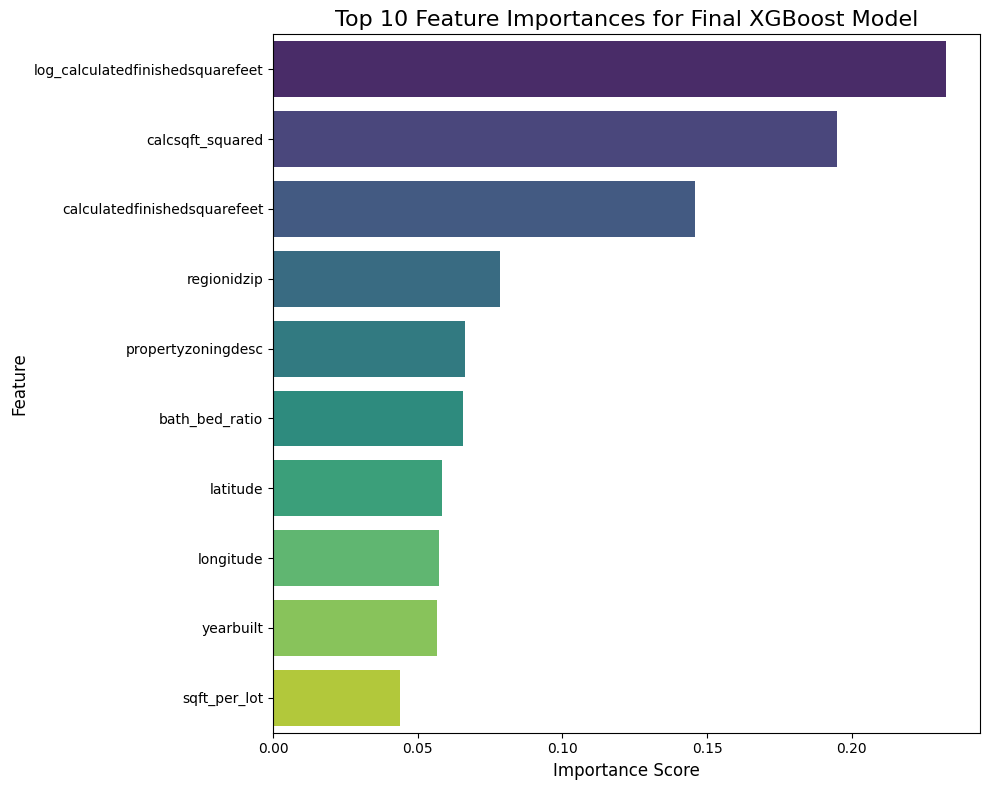

In [19]:
final_model = XGBRegressor(**best_params)
final_model.fit(X_train_sel, y_train)

# Extract feature importances from the trained final model
importances = final_model.feature_importances_

# Dynamically get feature names from the DataFrame used for training
feature_names = X_train_sel.columns

# Convert feature importances to a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title(f'Top {len(feature_names)} Feature Importances for Final XGBoost Model', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?

##### Answers:

1. Model Selection:

Final Model: We selected the XGBoost Regressor as the final model.

- Rationale: This decision was driven by its consistently strong performance throughout the project. It achieved the best overall result after hyperparameter tuning, with a final test MAE of 189,124.87. This was the lowest error achieved on the held-out test set among all models and tuning strategies. The GridSearchCV method proved most effective for tuning its parameters, demonstrating that a systematic search for the best configuration yielded the best outcome.

- Trade-offs: The primary trade-off with choosing XGBoost is a slight loss of interpretability compared to a simpler model like Linear Regression. However, given that the Linear Regression model performed very poorly and could not handle the engineered features effectively, its interpretability was of little practical value. The performance gain from XGBoost (a ~24% reduction in MAE compared to the best Linear Regression result) far outweighs the downside of its complexity. The goal is to predict property values as accurately as possible, and XGBoost proved to be the best tool for this task.

2. Revisiting an Early Decision:

- Decision: A key decision from Milestone 1 that was carried through to this milestone was the creation of polynomial and interaction features, specifically the calcsqft_squared feature (the square of calculatedfinishedsquarefeet).

- Initial Rationale: The initial hypothesis was that the relationship between a property's square footage and its value is not strictly linear. We expected that the value might increase at an accelerating rate with size (e.g., larger homes have more premium features), and adding a squared term would allow the model to capture this non-linearity.

- Reflection and Final Decision: This decision proved to be a double-edged sword. It was catastrophic for the Linear Regression model, causing numerical instability and an absurdly high MAE. However, for the tree-based models (Random Forest and XGBoost), it was highly beneficial. The feature selection process, particularly using tree_importance, consistently ranked calcsqft_squared as one of the most important features. It's clear that the non-linear relationship it represents is a powerful predictor of the target variable. We chose to keep this feature for our final model pipeline because its significant positive impact on the best-performing models (XGBoost and Random Forest). The final justification is the model's performance itself - the best scores were achieved using a feature set that included calcsqft_squared.

3. Lessons Learned:

- Insights: The most significant insight was the critical importance of the synergy between feature engineering and model selection. A feature that is highly valuable for one type of model (like a squared term for a tree-based ensemble) can be detrimental to another (like Linear Regression). This highlights that there is no "one-size-fits-all" approach to preprocessing. Furthermore, this project reinforced that for complex, real-world datasets, flexible, non-linear models like XGBoost and Random Forest often have a significant performance advantage over linear models.

- Next Steps: If we had more time, we would explore more sophisticated feature engineering, particularly related to location. While latitude and longitude are powerful, creating features based on proximity to amenities (schools, parks, public transport) or creating cluster-based location features could provide more nuance. We would also investigate more advanced hyperparameter tuning methods like Bayesian optimization (using Optuna), which can often find better parameter combinations more efficiently than grid or random search. Finally, stacking multiple models could be another avenue to potentially boost performance even further.